# Modelagem de distribuição de espécies utilizando a técnica MaxEntropy

## Instalações

In [2]:
# ! pip install geopandas --quiet
# ! pip install rasterio --quiet
# ! pip install earthpy --quiet

## Imports

In [3]:
from time import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import Bunch
from sklearn.datasets import fetch_species_distributions
from sklearn import svm, metrics

# if basemap is available, we'll use it.
# otherwise, we'll improvise later...
try:
    from mpl_toolkits.basemap import Basemap
    basemap = True
except ImportError:
    basemap = False

print(__doc__)

Automatically created module for IPython interactive environment


## Getting Environmental Variables

In [4]:
import numpy as np
from osgeo import gdal_array
import os

Diretorio base para salvar numpy arrays dos rasters

In [5]:
base_np_rasters_dir = 'C:/Users/mathe/Documents/Projeto TCC/tcc-ecological-niches-modeling/data/Rasters_As_Numpy_Arrays'

### Envirem

criando dicionario de rasters convertidos em numpy arrays

In [ ]:
root_envirem_dir = r'C:\Users\mathe\Documents\Projeto TCC\tcc-ecological-niches-modeling\data\Rasters\Envirem_variables'
rasters = {}
for (dirpath, dirnames, filenames) in os.walk(root_envirem_dir):
    print(filenames)
    for filename in filenames:
        if '.tif' in filename:
            filepath = os.path.join(root_envirem_dir, filename)
            rasterArray = gdal_array.LoadFile(filepath)
            rasters[filename] = rasterArray
    break

['current_30arcsec_annualPET.tif', 'current_30arcsec_aridityIndexThornthwaite.tif', 'current_30arcsec_climaticMoistureIndex.tif', 'current_30arcsec_continentality.tif', 'current_30arcsec_embergerQ.tif', 'current_30arcsec_growingDegDays0.tif', 'current_30arcsec_growingDegDays5.tif', 'current_30arcsec_maxTempColdest.tif', 'current_30arcsec_minTempWarmest.tif', 'current_30arcsec_monthCountByTemp10.tif', 'current_30arcsec_PETColdestQuarter.tif', 'current_30arcsec_PETDriestQuarter.tif', 'current_30arcsec_PETseasonality.tif', 'current_30arcsec_PETWarmestQuarter.tif', 'current_30arcsec_PETWettestQuarter.tif', 'current_30arcsec_thermicityIndex.tif', 'current_30arcsec_topoWet.tif', 'current_30arcsec_tri.tif']


In [ ]:
envirem_variables = np.stack([value for value in rasters.values()])
envirem_variables.shape

Empilhando rasters

Salvando os numpy arrays em arquivos externos no formato .npy

In [ ]:
with open(base_np_rasters_dir+'/envirem.npy', 'wb') as f:
    np.save(f, envirem_variables)

Recuperando rasters dos arquivos numpy

In [13]:
with open(base_np_rasters_dir+'/envirem.npy', 'rb') as f:
    envirem_variables = np.load(f)
envirem_variables.shape

FileNotFoundError: [Errno 2] No such file or directory: 'C://Users//mathe//Documents//Projeto TCC//tcc-ecological-niches-modeling//dataRasters_As_Numpy_Arrays//envirem.npy'

## Recuperando informações do raster com GDAL e Rasterio

In [ ]:
fp_raster_teste = '/content/drive/My Drive/TFC_MatheusSasso/Data/Rasters/Envirem_Rasters/SAmerica_current_30arcsec_geotiff_set2/current_30arcsec_embergerQ.tif'

### GDAL

In [ ]:
from osgeo import gdal
def get_raster_info_gdal(path):
    raster = gdal.Open(path)
    raster_infos_dict = {}
    raster_size_infos = raster.GetGeoTransform()

    Nx = raster.RasterXSize
    Ny = raster.RasterYSize
    grid_x = abs(raster_size_infos[1])
    grid_y = abs(raster_size_infos[5])

    raster_infos_dict['array'] = raster.ReadAsArray()
    raster_infos_dict['x_left_top_corner'] = raster_size_infos[0]
    raster_infos_dict['y_left_top_corner'] = raster_size_infos[3]
    raster_infos_dict['xmin'] = raster_size_infos[0]
    raster_infos_dict['xmax'] = raster_size_infos[0] + Nx*grid_x
    raster_infos_dict['ymin'] = raster_size_infos[3] - Ny*grid_y
    raster_infos_dict['ymax'] = raster_size_infos[3]
    raster_infos_dict['pixel_width'] = grid_x
    raster_infos_dict['pixel_height'] = grid_y
    raster_infos_dict['rotation_factor1'] = raster_size_infos[2]
    raster_infos_dict['rotation_factor2'] = raster_size_infos[4]
    raster_infos_dict['Nx'] = Nx
    raster_infos_dict['Ny'] = Ny
    return raster_infos_dict


In [ ]:
raster_infos_dict = get_raster_info_gdal(fp_raster_teste)
raster_infos_dict

### Rasteio


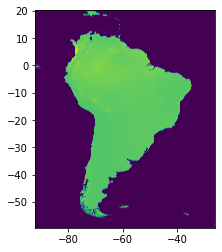

In [ ]:
import rasterio
from rasterio.plot import show
raster = rasterio.open(fp_raster_teste)
show((raster, 1))

In [ ]:
import rasterio
def get_raster_info_raster(path):
    raster = rasterio.open(path)
    raster_infos_dict = {}
    raster_infos_dict['array'] = raster.read(1)
    raster_infos_dict['x_left_top_corner'] = raster.meta['transform'][2]
    raster_infos_dict['y_left_top_corner'] = raster.meta['transform'][5]
    raster_infos_dict['xmin'] = raster.bounds[0]
    raster_infos_dict['xmax'] = raster.bounds[2]
    raster_infos_dict['ymin'] = raster.bounds[1]
    raster_infos_dict['ymax'] = raster.bounds[3]
    raster_infos_dict['pixel_width'] = abs(raster.meta['transform'][0])
    raster_infos_dict['pixel_height'] = abs(raster.meta['transform'][4])
    raster_infos_dict['rotation_factor1'] = raster.meta['transform'][1]
    raster_infos_dict['rotation_factor2'] = raster.meta['transform'][3]
    raster_infos_dict['no_data_vals'] = raster.meta['nodata']
    raster_infos_dict['crs'] = raster.crs
    raster_infos_dict['Nx'] = raster.width
    raster_infos_dict['Ny'] = raster.height
    return raster_infos_dict

In [ ]:
raster_infos_dict = get_raster_info_raster(fp_raster_teste)
raster_infos_dict

{'Nx': 7894,
 'Ny': 9549,
 'array': array([[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        ...,
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.]],
       dtype=float32),
 'crs': CRS.from_epsg(4326),
 'no_data_vals': -9999.0,
 'pixel_height': 0.008333333333333333,
 'pixel_width': 0.00833333333333334,
 'rotation_factor1': 0.0,
 'rotation_factor2': 0.0,
 'x_left_top_corner': -92.0166666666667,
 'xmax': -26.233333333333306,
 'xmin': -92.0166666666667,
 'y_left_top_corner': 20.0916666666667,
 'ymax': 20.0916666666667,
 'ymin': -59.483333333333306}

## Getting Occurrence Coordinates

In [ ]:
import geopandas as gpd
specie_dir = '/content/drive/My Drive/TFC_MatheusSasso/Data/GBIF_Ocurrences/Leucaena_Leucocephala_(lam)_De_Wit_2970418/Leucaena_Leucocephala_(lam)_De_Wit_2970418.shp'
data = gpd.read_file(specie_dir)

In [ ]:
print(data.crs)

None


In [ ]:
coordinates = np.array((np.array(data['LATITUDE']),np.array(data['LONGITUDE']))).T
coordinates[:5]

array([[ -9.755569, -36.663958],
       [ -9.562747, -35.763344],
       [ -4.898333, -65.355556],
       [ -4.898333, -65.355614],
       [ -4.860833, -65.334722]])

In [ ]:
from sklearn.model_selection import train_test_split
coordinates_train, coordinates_test, _, _ = train_test_split(coordinates,coordinates, test_size=0.2, random_state=42)

## Building Grids

In [ ]:
def construct_grids(batch,verbose=False):
    """Construct the map grid from the batch object

    Parameters
    ----------
    batch : Batch object
        The object returned by :func:`fetch_species_distributions`

    Returns
    -------
    (xgrid, ygrid) : 1-D arrays
        The grid corresponding to the values in batch.coverages
    """
  
    # x coordinates of the grid cells
    xgrid = np.arange(batch['xmin'], batch['xmax'], batch['pixel_width'])
    # y coordinates of the grid cells
    ygrid = np.arange(batch['ymin'], batch['ymax'], batch['pixel_height'])

    if verbose:
      print('xgrid shape: ',xgrid.shape)    
      print('xgrid: ',xgrid)    
      print('ygrid shape: ',ygrid.shape)    
      print('ygrid: ',ygrid)    

    return (xgrid, ygrid)

In [ ]:
(xgrid, ygrid) = construct_grids(raster_infos_dict,verbose=True)


xgrid shape:  (7894,)
xgrid:  [-92.01666667 -92.00833333 -92.         ... -26.25833333 -26.25
 -26.24166667]
ygrid shape:  (9549,)
ygrid:  [-59.48333333 -59.475      -59.46666667 ...  20.06666667  20.075
  20.08333333]


In [ ]:
# The grid in x,y coordinates
#X, Y = np.meshgrid(xgrid, ygrid[::-1])
#X, Y, X.shape, Y.shape

## Creating Species Bunch

In [ ]:
def create_species_bunch(species_name, train, test, environment_data, xgrid, ygrid):
    """Create a bunch with information about a particular organism

    This will use the test/train record arrays to extract the
    data specific to the given species name.
    """

    
    bunch = Bunch(name=species_name)
    points = dict(test=test, train=train)

    for label, pts in points.items():
        # choose points associated with the desired species
        bunch['pts_%s' % label] = pts

        # determine coverage values for each of the training & testing points
        Long = pts[:,1]
        Lat = pts[:,0]
        ix = np.searchsorted(xgrid,Long)
        iy = np.searchsorted(ygrid,Lat)

        #selecting the env value on the occurrence position
        bunch['cov_%s' % label] = environment_data[:, -iy, ix].T

    return bunch

**VERIFICAR MATCH DO CRS!!!**

In [ ]:
species = create_species_bunch('Leucaena_Leucocephala_(lam)_De_Wit',coordinates_train, coordinates_test,envirem_variables, xgrid, ygrid)

In [ ]:
background_points = np.c_[np.random.randint(low=0, high=raster_infos_dict['Ny'],size=10000),np.random.randint(low=0, high=raster_infos_dict['Nx'], size=10000)].T
background_points.shape,background_points

((2, 10000), array([[2357, 8734, 1333, ..., 8482, 5795, 7924],
        [3933, 4033, 2497, ..., 5149, 6438, 1978]]))

In [ ]:
envirem_variables[0]

(9549, 7894)

## One Class SVM Fit

In [ ]:
def fit_species_locations(species):
    
    # Fit, predict, and plot for each species.
    print("_" * 80)
    print("Modeling distribution of species '%s'" % species.name)

    # Standardize features
    mean = species.cov_train.mean(axis=0)
    std = species.cov_train.std(axis=0)
    train_cover_std = (species.cov_train - mean) / std

    # Fit OneClassSVM
    print(" - fit OneClassSVM ... ", end='')
    clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.5)
    clf.fit(train_cover_std)
    print("done.")

    return clf, mean, std 

## One Class SVM Predict

In [ ]:
def predict_species_locations(raster_infos_dict,land_reference,envirem_variables,clf,mean,std):
    
    print(" - predict species distribution")
    # Predict species distribution using the training data
    Z = np.ones((raster_infos_dict['Ny'], raster_infos_dict['Nx']), dtype=np.float64)

    # We'll predict only for the land points.
    idx = np.where(land_reference > -9999)
    coverages_land = envirem_variables[:, idx[0], idx[1]].T

    pred = clf.decision_function((coverages_land - mean) / std)
    
    #pass all values to minimum
    Z *= pred.min()

    Z[idx[0], idx[1]] = pred

    levels = np.linspace(Z.min(), Z.max(), 50)
    Z[land_reference == -9999] = -9999

    return Z

## Plots

In [ ]:
def plot_species_distribution(xgrid,ygrid,land_reference,species,Z,background_points,clf):
    # The grid in x,y coordinates
    X, Y = np.meshgrid(xgrid, ygrid[::-1])

    #  plot coastlines from coverage"
    print(" - plot coastlines from coverage")
    plt.contour(X, Y, land_reference, levels=[-9998], colors="k", linestyles="solid")
    plt.xticks([])
    plt.yticks([])

    # plot contours of the prediction
    plt.contourf(X, Y, Z, levels=levels, cmap=plt.cm.Reds)
    plt.colorbar(format='%.2f')

    # scatter training/testing points
    plt.scatter(species['pts_train'][:,1], species['pts_train'][:,0],s=2 ** 2, c='black', marker='^', label='train')
    plt.scatter(species['pts_test'][:,1], species['pts_test'][:,0], s=2 ** 2, c='black',  marker='x', label='test')
    plt.legend()
    plt.title(species.name)
    plt.axis('equal')
    
    # Compute AUC with regards to background points
    pred_background = Z[background_points[0], background_points[1]]
    pred_test = clf.decision_function((species.cov_test - mean) / std)
    scores = np.r_[pred_test, pred_background]
    y = np.r_[np.ones(pred_test.shape), np.zeros(pred_background.shape)]
    fpr, tpr, thresholds = metrics.roc_curve(y, scores)
    roc_auc = metrics.auc(fpr, tpr)
    plt.text(-35, -70, "AUC: %.3f" % roc_auc, ha="right")
    print("\n Area under the ROC curve : %f" % roc_auc)

    


## Model Species Distribution

In [ ]:
def create_species_distribution(species_name,envirem_variables,raster_infos_dict,coordinates):
    """
    Plot the species distribution.
    """
    # splitting coordinates in train and test
    coordinates_train, coordinates_test, _, _ = train_test_split(coordinates,coordinates, test_size=0.2, random_state=42)

    # Set up the data grid
    xgrid, ygrid = construct_grids(raster_infos_dict)

    species = create_species_bunch(species_name,coordinates_train, coordinates_test,envirem_variables, xgrid, ygrid)

    # background points (grid coordinates) for evaluation
    # these are aleatory points just to go on ROC curve
    np.random.seed(13)
    background_points = np.c_[np.random.randint(low=0, high=raster_infos_dict['Ny'],size=10000),np.random.randint(low=0, high=raster_infos_dict['Nx'], size=10000)].T

    #This will help us decide between land and water.
    land_reference = envirem_variables[5] #-> Tenho que ter um raster da região vazia

    #Training
    clf, mean, std = fit_species_locations(species)

    #Inference   
    Z = predict_species_locations(raster_infos_dict,land_reference,envirem_variables,clf,mean,std)

    import pdb;dbp.set_trace()

    # The grid in x,y coordinates
    X, Y = np.meshgrid(xgrid, ygrid[::-1])

    #  plot coastlines from coverage"
    print(" - plot coastlines from coverage")
    plt.contour(X, Y, land_reference, levels=[-9998], colors="k", linestyles="solid")
    plt.xticks([])
    plt.yticks([])

    # plot contours of the prediction
    plt.contourf(X, Y, Z, levels=levels, cmap=plt.cm.Reds)
    plt.colorbar(format='%.2f')

    # scatter training/testing points
    plt.scatter(species['pts_train'][:,1], species['pts_train'][:,0],s=2 ** 2, c='black', marker='^', label='train')
    plt.scatter(species['pts_test'][:,1], species['pts_test'][:,0], s=2 ** 2, c='black',  marker='x', label='test')
    plt.legend()
    plt.title(species.name)
    plt.axis('equal')
    
    # Compute AUC with regards to background points
    pred_background = Z[background_points[0], background_points[1]]
    pred_test = clf.decision_function((species.cov_test - mean) / std)
    scores = np.r_[pred_test, pred_background]
    y = np.r_[np.ones(pred_test.shape), np.zeros(pred_background.shape)]
    fpr, tpr, thresholds = metrics.roc_curve(y, scores)
    roc_auc = metrics.auc(fpr, tpr)
    plt.text(-35, -70, "AUC: %.3f" % roc_auc, ha="right")
    print("\n Area under the ROC curve : %f" % roc_auc)



## Teste junto


In [ ]:
from sklearn.model_selection import train_test_split
def plot_species_distribution(species_name,envirem_variables,raster_infos_dict,coordinates):
    """
    Plot the species distribution.
    """

    t0 = time()

    # splitting coordinates in train and test
    
    coordinates_train, coordinates_test, _, _ = train_test_split(coordinates,coordinates, test_size=0.2, random_state=42)

    # Set up the data grid
    xgrid, ygrid = construct_grids(raster_infos_dict)

    # The grid in x,y coordinates
    X, Y = np.meshgrid(xgrid, ygrid[::-1])

    species = create_species_bunch(species_name,coordinates_train, coordinates_test,envirem_variables, xgrid, ygrid)

    # background points (grid coordinates) for evaluation
    # these are aleatory points just to go on ROC curve
    np.random.seed(13)
    background_points = np.c_[np.random.randint(low=0, high=raster_infos_dict['Ny'],size=10000),np.random.randint(low=0, high=raster_infos_dict['Nx'], size=10000)].T

    #This will help us decide between land and water.
    land_reference = envirem_variables[5] #-> Tenho que ter um raster da região vazia

    # Fit, predict, and plot for each species.
    print("_" * 80)
    print("Modeling distribution of species '%s'" % species.name)

    # Standardize features
    mean = species.cov_train.mean(axis=0)
    std = species.cov_train.std(axis=0)
    train_cover_std = (species.cov_train - mean) / std

    # Fit OneClassSVM
    print(" - fit OneClassSVM ... ", end='')
    clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.5)
    clf.fit(train_cover_std)
    print("done.")
  
    print(" - plot coastlines from coverage")
    plt.contour(X, Y, land_reference, levels=[-9998], colors="k", linestyles="solid")
    plt.xticks([])
    plt.yticks([])

    print(" - predict species distribution")
    # Predict species distribution using the training data
    Z = np.ones((raster_infos_dict['Ny'], raster_infos_dict['Nx']), dtype=np.float64)

    # We'll predict only for the land points.
    idx = np.where(land_reference > -9999)
    coverages_land = envirem_variables[:, idx[0], idx[1]].T

    pred = clf.decision_function((coverages_land - mean) / std)
    
    #pass all values to minimum
    Z *= pred.min()

    Z[idx[0], idx[1]] = pred

    levels = np.linspace(Z.min(), Z.max(), 50)
    Z[land_reference == -9999] = -9999

    # plot contours of the prediction
    plt.contourf(X, Y, Z, levels=levels, cmap=plt.cm.Reds)
    plt.colorbar(format='%.2f')

    # scatter training/testing points
    plt.scatter(species['pts_train'][:,1], species['pts_train'][:,0],s=2 ** 2, c='black', marker='^', label='train')
    plt.scatter(species['pts_test'][:,1], species['pts_test'][:,0], s=2 ** 2, c='black',  marker='x', label='test')
    plt.legend()
    plt.title(species.name)
    plt.axis('equal')
    
    # Compute AUC with regards to background points
    pred_background = Z[background_points[0], background_points[1]]
    pred_test = clf.decision_function((species.cov_test - mean) / std)
    scores = np.r_[pred_test, pred_background]
    y = np.r_[np.ones(pred_test.shape), np.zeros(pred_background.shape)]
    fpr, tpr, thresholds = metrics.roc_curve(y, scores)
    roc_auc = metrics.auc(fpr, tpr)
    plt.text(-35, -70, "AUC: %.3f" % roc_auc, ha="right")
    print("\n Area under the ROC curve : %f" % roc_auc)

    print("\ntime elapsed: %.2fs" % (time() - t0))

In [ ]:
plot_species_distribution('Leucaena_Leucocephala_(lam)_De_Wit',envirem_variables,raster_infos_dict,coordinates)

________________________________________________________________________________
Modeling distribution of species 'Leucaena_Leucocephala_(lam)_De_Wit'
 - fit OneClassSVM ... done.
 - plot coastlines from coverage
 - predict species distribution
